Worklist:
We probably need to do a spatial correlation analysis and fit a covariance function with it for both reconstruction and ground measurements. A new idea about the kNN estimate is we could separate the pixels into small regions and only use a few pixels locally to run kNN and then combine them together for estimating the entire region

In [1]:
__author__ = 'zeshi'
import numpy as np
import gdal
from scipy.stats import pearsonr, linregress
import pickle
import os
from gdal import GA_ReadOnly
from datetime import date, timedelta
from matplotlib import pyplot as plt
from sklearn.neighbors import KDTree
from sklearn.cross_validation import KFold
from skimage.transform import resize
from skimage import feature
from sklearn.preprocessing import StandardScaler, robust_scale
from skimage.morphology import square, dilation
import seaborn as sns
import matplotlib as mpl
import pandas as pd
from multiprocessing import Pool
from functools import partial
mpl.rc("font", family="Helvetica")
mpl.rc('font', size=18)

%matplotlib inline

###### The following function find the unique grid that sensors belong to in the spatial reconstruction SWE
input:
a - the belonging indices of the sensors

In [ ]:
def unique(a):
    order = np.lexsort(a.T)
    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1)
    return a[ui]

###### The following function find the file name of the node data
input:
dir_name - The directory name to find the data
site_name - The name of the site, e.g. 
    
    site_names = ["Alpha", "Bear_trap", "Caples", "duncan", "Echo", "MTL", "OC", "Robbs_Saddle", "Schneider", "Vanvleck"]
    
node_num - The index of the node, from 1 to 10

In [ ]:
def find_node_fn(dir_name, site_name, node_num):
    file_list = os.listdir(dir_name)
    file_list = [filename for filename in file_list if filename.endswith(".csv")]
    all_node_fn = [filename for filename in file_list if filename.startswith(site_name)]
    sub_string = "_" + str(node_num)
    for temp_node_fn in all_node_fn:
        if sub_string in temp_node_fn:
            return dir_name + "/" + temp_node_fn

###### The following function returns indices on a raster file of all nodes within a site

In [ ]:
def nodes_raster_indices(site_name):
    fn = "site_node_coords/" + site_name + "_coords.csv"
    all_nodes_coords = np.loadtxt(fn, delimiter=",")
    from gdal import GA_ReadOnly
    spatial_data = gdal.Open("2001/01APR2001.tif", GA_ReadOnly)
    spatial_data_georef = spatial_data.GetGeoTransform()
    all_nodes_indices_Y = ((all_nodes_coords[:, 0] - \
                            spatial_data_georef[3]) / spatial_data_georef[5]).astype(int)
    all_nodes_indices_X = ((all_nodes_coords[:, 1] - \
                            spatial_data_georef[0]) / spatial_data_georef[1]).astype(int)
    all_nodes_indices = np.column_stack((all_nodes_indices_Y, all_nodes_indices_X))
    return all_nodes_indices, unique(all_nodes_indices)

In [ ]:
a, b = nodes_raster_indices("Alpha")
i = b[0]
print a[:, 0]==i[0]
print np.where((a[:, 0]==i[0]) & (a[:, 1]==i[1]))

###### The following function format the sensor data by the pixel on the spatial data
    Input: The default of site_node_dict is None, but could be inserted as a dict type object. The format should be {"Alpha":[1,2,3,4,5], "Bear_trap":[1,2,3],...}
    
    Output: It will return all sensor data [sensor, time], and all nodes indices on the raster data [y_idx, x_idx], and all the site_name and sensor_node_num of each individual index, the format of which is a dict:{index_raster_pixel:[(site_name, sensor_node_num),(site_name, sensor_node_num)], ...}

In [ ]:
def format_sensor():
    site_names = ["Alpha", "Bear_trap", "Caples", "duncan", "Echo", 
                  "MTL", "OC", "Robbs_Saddle", "Schneider", "Vanvleck"]
    all_sites_nodes_raster_indices = np.empty((0, 2))
    all_data = 0.
    siteName_nodeNum_of_unique_indices = {}
    key_counter = 0
    for i, site_name in enumerate(site_names): # Iterate over all sites
        all_nodes_indices, all_nodes_unique_indices = nodes_raster_indices(site_name) # For 
        # each site, find all nodes indices and unique indices
        for j, unique_index in enumerate(all_nodes_unique_indices):
            if key_counter in siteName_nodeNum_of_unique_indices.keys():
                pass
            else:
                siteName_nodeNum_of_unique_indices[key_counter] = []
            nodes_num = []
            for k, node_index in enumerate(all_nodes_indices):
                if np.array_equal(node_index, unique_index):
                    nodes_num.append(k + 1)
            swe_sum = 0.
            node_number = 0.
            for node_num in nodes_num:
                node_fn = find_node_fn("Level2_all_daily_density", site_name, node_num)
                if node_fn:
                    siteName_nodeNum_of_unique_indices[key_counter].append((site_name, node_num))
                    node_data = pd.read_csv(node_fn, sep=",", header=0)
                    # feature screeening first and then save data as panel data
                    node_swe = node_data[["snow_depth"]].as_matrix() * \
                                node_data[["snow_density"]].as_matrix()
                    node_swe[node_swe <= 0.] = 0.
                    swe_sum += node_swe
                    node_number += 1.
            if node_number != 0.:
                key_counter += 1
                all_sites_nodes_raster_indices = np.vstack((all_sites_nodes_raster_indices, 
                                             unique_index))
                swe_avg = swe_sum / node_number
                if i == 0 and j == 0:
                    all_data = swe_avg.T
                else:
                    all_data = np.vstack((all_data, swe_avg.T))
    np.save("2014_sensor_data_formated.npy", all_data)
    np.save("ar_nodes_raster_indices.npy", all_sites_nodes_raster_indices)
    pickle.dump(siteName_nodeNum_of_unique_indices, 
                open("siteName_nodeNum_of_unique_indices.p", "wb"))
    return all_data.T, all_sites_nodes_raster_indices, siteName_nodeNum_of_unique_indices

In [ ]:
all_nodes_data, all_nodes_indices, siteName_nodeNum_of_unique_indices = format_sensor()

###### The following function will format the reconstruction data into the same format as the sensor data
    input: 
        idx, indices of [y, x] index on the reconstruction data
        year_range, two element array/list, with starting year and ending year
    output:
        Output will be an library with all the SWE data of the reconstruction in the form of
        [y, x] = [time, node]
        Time starts from 4/1 to 7/31 in each year in the range

In [ ]:
def format_reconstruction(idx, year_range):
    idx = idx.T
    idx = (np.array(idx[0]).astype(int), np.array(idx[1]).astype(int))
    library = np.empty((0, len(idx[0])))
    name = []
    for year in range(year_range[0], year_range[1] + 1):
        start_date = date(year, 3, 1)
        end_date = date(year, 7, 31)
        temp_date = start_date
        while temp_date <= end_date:
            check_fn = str(year) + "/" + str(temp_date.day).zfill(2) + \
                   temp_date.strftime("%B")[0:3].upper() + str(year) + ".tif"
            temp_data = gdal.Open(check_fn, GA_ReadOnly).ReadAsArray()
            library = np.vstack((library, temp_data[idx]))
            name.append(check_fn)
            temp_date += timedelta(days=1)
    library_fn = "library" + "_" + str(year_range[0]) + "_" + str(year_range[1]) + "_march.npy"
    library_file_name_list_fn = "library_file_name_list" + "_" + str(year_range[0]) + \
                                "_" + str(year_range[1]) + "_march.p"
    np.save(library_fn, library)
    pickle.dump(name, open(library_file_name_list_fn, "wb"))
    return library

###### This function will first do a feature screening over all the pixels <- sensors, and then use the selected pixels to regenerate historical data from 2001-2013 from the reconstruction data.

In [ ]:
def filter_nodes():
    correlation = []
    recon_pixels_values = np.load("library_2014_2014.npy")
    recon_pixels_values = robust_scale(recon_pixels_values, axis=0).T
    ts_length = recon_pixels_values.shape[1]
    start_idx = (date(2014, 4, 1) - date(2013, 10, 1)).days
    nodes_pixels_values = np.load("2014_sensor_data_formated.npy")[:, start_idx:(start_idx + 
                                                                       ts_length)]
    nodes_pixels_values = robust_scale(nodes_pixels_values, axis=1)
    pixel_node_correlation_p = []
    for recon_pixel_value, node_pixel_value  in zip(recon_pixels_values, nodes_pixels_values):
        slope, intercept, r_value, p_value, std_err = linregress(node_pixel_value, 
                                                                 recon_pixel_value)
        pixel_node_correlation_p.append(p_value)
    pixel_node_correlation_p = np.array(pixel_node_correlation_p)
    pixel_conserved = np.where(pixel_node_correlation_p <= 0.001)[0]
    selected_indices = np.load("ar_nodes_raster_indices.npy")[pixel_conserved]
    selected_sensor_data = np.load("2014_sensor_data_formated.npy")[pixel_conserved] / 100.0
    np.save("2014_sensor_data_filtered.npy", selected_sensor_data)
    #     print selected_sensor_data.shape
    plt.figure(figsize=(15, 20))
    plt.imshow(selected_sensor_data)
    plt.colorbar()
    plt.show()
    historical_library = format_reconstruction(selected_indices, [2014, 2014])
    return historical_library, selected_sensor_data

In [ ]:
def check_node_recon_beta():
    correlation = []
    recon_pixels_values_raw = np.load("library_2014_2014.npy")
    recon_pixels_values = robust_scale(recon_pixels_values_raw, axis=0).T
    ts_length = recon_pixels_values.shape[1]
    start_idx = (date(2014, 4, 1) - date(2013, 10, 1)).days
    nodes_pixels_values_raw = np.load("2014_sensor_data_formated.npy")[:, start_idx:(start_idx + 
                                                                       ts_length)]
    nodes_pixels_values = robust_scale(nodes_pixels_values_raw, axis=1)
    pixel_node_correlation_p = []
    for recon_pixel_value, node_pixel_value  in zip(recon_pixels_values, nodes_pixels_values):
        slope, intercept, r_value, p_value, std_err = linregress(node_pixel_value, 
                                                                 recon_pixel_value)
        pixel_node_correlation_p.append(p_value)
    pixel_node_correlation_p = np.array(pixel_node_correlation_p)
    pixel_conserved = np.where(pixel_node_correlation_p <= 0.001)[0]
    recon_pixels_values_selected = recon_pixels_values_raw.T[pixel_conserved]
    nodes_pixels_values_selected = nodes_pixels_values_raw[pixel_conserved]
    fig, axarr = plt.subplots(2, 1, figsize=(15, 15), sharex=True)
    axarr[0].imshow(recon_pixels_values_selected, vmax=1.1, vmin=0.)
    im = axarr[1].imshow(nodes_pixels_values_selected / 100.0, vmax=1.1, vmin = 0.)
    cbar_ax = fig.add_axes([0.9, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    plt.show()
    print np.max(nodes_pixels_values_selected / 100.0)
#     slope_list = []
#     for recon_pixel_value_selected, node_pixel_value_selected  in zip(recon_pixels_values_selected, 
#                                                     nodes_pixels_values_selected):
#         slope, intercept, r_value, p_value, std_err = linregress(node_pixel_value_selected[:35]/100., 
#                                                                  recon_pixel_value_selected[:35])
#         print slope
#         slope_list.append(slope)
#     return slope_list

In [ ]:
def corr_matrix():
    correlation = []
    recon_pixels_values_raw = np.load("library_2014_2014.npy")
    recon_pixels_values = robust_scale(recon_pixels_values_raw, axis=0).T
    ts_length = recon_pixels_values.shape[1]
    start_idx = (date(2014, 4, 1) - date(2013, 10, 1)).days
    nodes_pixels_values_raw = np.load("2014_sensor_data_formated.npy")[:, start_idx:(start_idx + 
                                                                       ts_length)]
    nodes_pixels_values = robust_scale(nodes_pixels_values_raw, axis=1)
    pixel_node_correlation_p = []
    for recon_pixel_value, node_pixel_value  in zip(recon_pixels_values, nodes_pixels_values):
        slope, intercept, r_value, p_value, std_err = linregress(node_pixel_value, 
                                                                 recon_pixel_value)
        pixel_node_correlation_p.append(p_value)
    pixel_node_correlation_p = np.array(pixel_node_correlation_p)
    pixel_conserved = np.where(pixel_node_correlation_p <= 0.001)[0]
    recon_pixels_values_selected = recon_pixels_values_raw.T[pixel_conserved]
    nodes_pixels_values_selected = nodes_pixels_values_raw[pixel_conserved]
    recon_corr = np.corrcoef(recon_pixels_values_selected)
    nodes_corr = np.corrcoef(nodes_pixels_values_selected)
    recon_nodes_corr = np.corrcoef(recon_pixels_values_selected, nodes_pixels_values_selected)
    recon_nodes_corr = recon_nodes_corr[0:21, 21:]

    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(recon_nodes_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(ncols=3, nrows=1, figsize=(7.5, 3))

    # Generate a custom colormap
    cmap = sns.light_palette("purple", as_cmap=True)

    cbar_ax = f.add_axes([0.9, 0.25, 0.02, 0.5])

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(recon_corr, mask=mask, cmap=cmap, vmax=1.0,
                vmin=0.5,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar=0, ax=ax[0])
    ax[0].set_xlabel('Reconstruction')
    ax[0].set_ylabel('Reconstruction')

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(nodes_corr, mask=mask, cmap=cmap, vmax=1.0,
                vmin=0.5,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, cbar=0, ax=ax[1])
    ax[1].set_xlabel('Ground measurements')
    ax[1].set_ylabel('Ground measurements')

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(recon_nodes_corr, mask=mask, cmap=cmap, vmax=1.0,
                vmin=0.5,
                square=True, xticklabels=5, yticklabels=5,
                linewidths=.5, ax=ax[2], cbar_ax=cbar_ax)
    ax[2].set_xlabel('Ground measurements')
    ax[2].set_ylabel('Reconstruction')
    f.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig('corr_matrix.eps')
    plt.show()

In [ ]:
slope_list = check_node_recon_beta()

In [ ]:
def kNN_kfold_CV(library_year_range, current_year, n_folds, k_knn = 10, return_ = "RMSE"):
    library_fn = "library_" + str(library_year_range[0]) + "_" + \
                 str(library_year_range[1]) + ".npy"
    library = np.load(library_fn)
    sensor_data_fn = str(current_year) + "_sensor_data_filtered.npy"
    sensor_data = np.load(sensor_data_fn).T[130:220]
    kf = KFold(library.shape[1], n_folds=n_folds, shuffle=True)
    if return_ == "RMSE" or return_ == "all_error":
        cv_error = np.array([])
    elif return_ == "true_vs_predict":
        observed = np.array([])
        predicted = np.array([])
        pixel_index = np.array([])
    for train_index, test_index in kf:
        kf_library_train = library[:, train_index]
        kf_library_test = library[:, test_index]
        kf_sensor_train = sensor_data[:, train_index]
        kf_sensor_test = sensor_data[:, test_index]
        KNN = KDTree(kf_library_train)
        if return_ == "RMSE":
            error = np.array([])
            for temp_sensor_train, temp_sensor_test in zip(kf_sensor_train, kf_sensor_test):
                dist, index = KNN.query(temp_sensor_train.reshape(1, -1), k=k_knn)
                temp_sensor_predict = np.mean(kf_library_test[index[0]], axis=0)
                temp_err = (temp_sensor_predict - temp_sensor_test) ** 2
                error = np.append(error, temp_err)
                cv_error = np.append(cv_error, np.sqrt(np.mean(error)))
        elif return_ == "all_error":
            for temp_sensor_train, temp_sensor_test in zip(kf_sensor_train, kf_sensor_test):
                dist, index = KNN.query(temp_sensor_train.reshape(1, -1), k=k_knn)
                temp_sensor_predict = np.mean(kf_library_test[index[0]], axis=0)
                temp_err = temp_sensor_predict - temp_sensor_test
                # print temp_err
                cv_error = np.append(cv_error, temp_err)
        elif return_ == "true_vs_predict":
            for temp_sensor_train, temp_sensor_test in zip(kf_sensor_train, kf_sensor_test):
                dist, index = KNN.query(temp_sensor_train.reshape(1, -1), k=k_knn)
                temp_sensor_predict = np.mean(kf_library_train[index[0]], axis=0)
                observed = np.append(observed, temp_sensor_train)
                predicted = np.append(predicted, temp_sensor_predict)
                pixel_index = np.append(pixel_index, train_index)
#                 print len(observed), len(pixel_index)
    if return_ == "RMSE":
        return np.nanmean(cv_error), np.nanstd(cv_error)
    elif return_ == "all_error":
        return cv_error
    elif return_ == "true_vs_predict":
        return observed, predicted, pixel_index

In [ ]:
def kNN_interpolate(k_knn = 20):
    library_fn = "library_2001_2013.npy"
    library = np.load(library_fn)
    library_spatial_fn = pickle.load(open("library_file_name_list_2001_2013.p"))
    sensor_data = np.load("2014_sensor_data_filtered.npy").T[151:220]
    KNN = KDTree(library)
    map_list = []
    for i in range(0, 10):
        print i
        sensor = sensor_data[i*7]
        dist, ind = KNN.query(np.array([sensor]), k=k_knn)
        total_swe_amr = 0.
        total_weight = 0.
        for temp_dist, temp_ind in zip(dist[0], ind[0]):
            temp_fn = library_spatial_fn[temp_ind]
            total_swe_amr += 1./temp_dist * clip_mask_reconstructions(temp_fn)
            total_weight += 1./temp_dist
        map_list.append(total_swe_amr / total_weight)
    return map_list

testing the sensitivity of kNN when increasing the number of samples in the KD Tree

RMSE with 10% reconstruction samples is 0.206735206106
RMSE with 11% reconstruction samples is 0.202000313798
RMSE with 12% reconstruction samples is 0.202534257456
RMSE with 13% reconstruction samples is 0.206811369422
RMSE with 13% reconstruction samples is 0.198154555191
RMSE with 14% reconstruction samples is 0.20372648641
RMSE with 15% reconstruction samples is 0.204019986527
RMSE with 17% reconstruction samples is 0.20435466518
RMSE with 17% reconstruction samples is 0.203774378091
RMSE with 18% reconstruction samples is 0.197243294387
RMSE with 19% reconstruction samples is 0.201254267223
RMSE with 20% reconstruction samples is 0.191126771576
RMSE with 21% reconstruction samples is 0.195716308806
RMSE with 22% reconstruction samples is 0.195440034557
RMSE with 23% reconstruction samples is 0.196578746348
RMSE with 24% reconstruction samples is 0.194020817496
RMSE with 25% reconstruction samples is 0.200281149457
RMSE with 26% reconstruction samples is 0.19573671657
RMSE with 27%

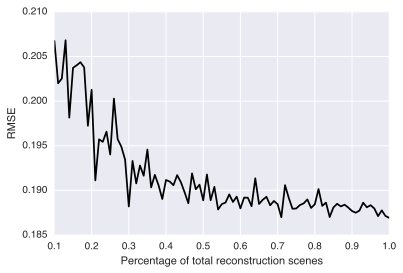

In [5]:
def kNN_interpolate_sensitivity(k_knn = 20, size=0.25):
    library_fn = "library_2001_2013.npy"
    library = np.load(library_fn)
#     library_spatial_fn = pickle.load(open("library_file_name_list_2001_2013.p"))
    sensor_data = np.load("2014_sensor_data_filtered.npy").T[151:220]
    random_sample_index = np.random.randint(0, high=len(library), size=int(size*len(library)), dtype='int')
    library_sensitivity = library[random_sample_index, :]
#     library_spatial_fn_sensitivity = [library_spatial_fn[i] for i in random_sample_index]
    kNN = KDTree(library_sensitivity)
    error = None
    for i in range(0, len(sensor_data)):
        sensor = sensor_data[i]
        dist, ind = kNN.query(np.array([sensor]), k=k_knn)
        ind = ind[0]
        kNN_result = library_sensitivity[ind]
        kNN_result_avg = np.nanmean(kNN_result, axis=0)
        if error is not None:
            error = np.append(error, sensor - kNN_result_avg)
        else:
            error = sensor - kNN_result_avg
    rmse = np.sqrt(np.mean(error ** 2))
    print "RMSE with", str(int(size*100)) + "%", "reconstruction samples is", str(rmse)
    return rmse
np.random.seed(1)
percentage_list = np.arange(0.1, 1.01, 0.01)
rmse_list = []
for percentage in np.arange(0.1, 1.01, 0.01):
    temp_rmse = kNN_interpolate_sensitivity(k_knn=20, size=percentage)
    rmse_list.append(temp_rmse)
plt.plot(percentage_list, rmse_list, '-k')
plt.xlabel("Percentage of total reconstruction scenes")
plt.ylabel("RMSE")
plt.show()

It does not matter if bootstrap is used in the result

In [ ]:
def kNN_bootstrap_results(k_knn = 20):
    np.random.seed(1)
    library_fn = "library_2001_2013.npy"
    library = np.load(library_fn)
    library_spatial_fn = pickle.load(open("library_file_name_list_2001_2013.p"))
    sensor_data = np.load("2014_sensor_data_filtered.npy").T[151:220]
    kNN = KDTree(library)
    rmse_list = []
    bootstrap_size = np.arange(10, 500, 10)
    for num_bootstrap in bootstrap_size:
        bootstrap_idx = np.random.randint(0, k_knn, (num_bootstrap, k_knn))
        error = None
        for i in range(0, len(sensor_data)):
            sensor = sensor_data[i]
            dist, ind = kNN.query(np.array([sensor]), k=k_knn)
            ind = ind[0]
            kNN_result = library[ind]
            bootstrap_result = np.zeros((num_bootstrap, len(sensor)))
            for j, temp_idx in enumerate(bootstrap_idx):
                bootstrap_result[j] = np.nanmean(kNN_result[temp_idx], axis=0)
            if error is None:
                error = sensor - np.nanmean(bootstrap_result, axis=0)
            else:
                error = np.append(error, sensor - np.nanmean(bootstrap_result, axis=0))
        temp_rmse = np.sqrt(np.mean(error**2))
        rmse_list.append(temp_rmse)
    return bootstrap_size, rmse_list

bs, rl = kNN_bootstrap_results(k_knn = 20)
plt.plot(bs, rl, '-k')

Try bootstrapping the samples included. Result does not change much

In [7]:
def kNN_bootstrap_samples(k_knn = 20):
    np.random.seed(1)
    library_fn = "library_2001_2013.npy"
    library = np.load(library_fn)
    library_spatial_fn = pickle.load(open("library_file_name_list_2001_2013.p"))
    sensor_data = np.load("2014_sensor_data_filtered.npy").T[151:220]
    bootstrap_size = np.arange(10, 500, 10)
    rmse_list = []
    for num_bootstrap in bootstrap_size:
        print num_bootstrap
        bootstrap_idx = np.random.randint(0, len(library), (num_bootstrap, len(library)))
        error = None
        for i in range(0, len(sensor_data)):
            sensor = sensor_data[i]
            kNN_result_bootstrap = np.zeros((num_bootstrap, len(sensor)))
            partial_para_kNN = partial(parallel_kNN, sensor=sensor, library=library, k_knn=k_knn)
            pool = Pool(processes=12)
            kNN_result_bootstrap = pool.map(partial_para_kNN, bootstrap_idx)
            kNN_result_bootstrap_sum = 0.
            for temp_result in kNN_result_bootstrap:
                kNN_result_bootstrap_sum += temp_result
            kNN_result_bootstrap_avg = kNN_result_bootstrap_sum / len(kNN_result_bootstrap)
            pool.close()
            pool.join()
#             kNN_result_bootstrap_avg = np.nanmean(kNN_result_bootstrap, axis=0)
            if error is not None:
                error = np.append(error, sensor - kNN_result_bootstrap_avg)
            else:
                error = sensor - kNN_result_bootstrap_avg
        rmse_list.append(np.sqrt(np.mean(error**2)))
    return bootstrap_size, rmse_list

In [2]:
def parallel_kNN(temp_bootstrap_idx, sensor=None, library=None, k_knn=20):
    bootstrap_library = library[temp_bootstrap_idx]
    kNN = KDTree(bootstrap_library)
    dist, ind = kNN.query(np.array([sensor]), k=k_knn)
    ind = ind[0]
    kNN_result = bootstrap_library[ind]
    kNN_result_avg = np.nanmean(kNN_result, axis=0)
    return kNN_result_avg

Try bootstrapping the independant variables being used

In [16]:
def randomized_features(k_knn = 20, max_feature=10):
    np.random.seed(1)
    library_fn = "library_2001_2013.npy"
    library = np.load(library_fn)
    library_spatial_fn = pickle.load(open("library_file_name_list_2001_2013.p"))
    sensor_data = np.load("2014_sensor_data_filtered.npy").T[151:220]
    bootstrap_size = np.arange(10, 120, 10)
    partial_random_feature_kNN = partial(kNN_random_features_samples, library=library, sensor_data=sensor_data, max_feature=max_feature, k_knn=k_knn)
    pool = Pool(processes=12)
    rmse_list = pool.map(partial_random_feature_kNN, bootstrap_size)
    pool.close()
    pool.join()
    return bootstrap_size, rmse_list

In [38]:
def ensemble_kNN_scatter(k_knn=1, max_feature=21):
    np.random.seed(1)
    np.random.seed(1)
    library_fn = "library_2001_2013.npy"
    library = np.load(library_fn)
    library_spatial_fn = pickle.load(open("library_file_name_list_2001_2013.p"))
    sensor_data = np.load("2014_sensor_data_filtered.npy").T[151:220]
    bootstrap_size = 300
    true, pred = kNN_random_features_samples(bootstrap_size, library=library,sensor_data=sensor_data,max_feature=max_feature, k_knn=k_knn,pred_true=True)
    plt.scatter(true, pred)
    return true, pred

300


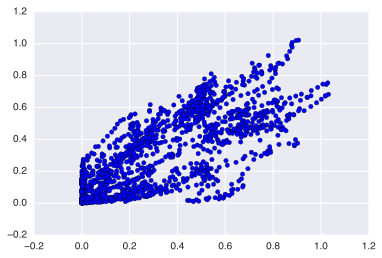

In [39]:
true, pred = ensemble_kNN_scatter(k_knn=1, max_feature=21)

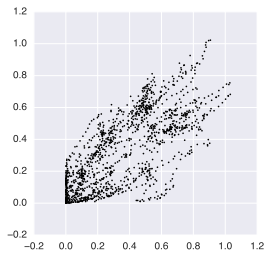

In [41]:
plt.figure(figsize=(4, 4))
plt.scatter(true, pred, facecolor='black', edgecolor='none', s=3.)

10
20
30
40
50
60
70
80
90
110
100
10
20
30
40
50
60
70
80
90
100
110
10
20
30
40
50
70
60
80
90
100
110
10
20
30
40
50
60
70
80
90
100
110
10
20
30
40
50
60
70
80
90
100
110


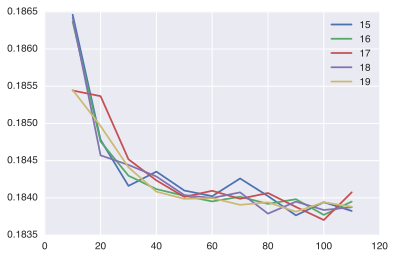

In [25]:
max_feature_list = np.arange(15, 20, 1)
max_feature_list_str = []
for temp_max_feature in max_feature_list:
    bootstrap_size, rmse_list = randomized_features(k_knn=1, max_feature=temp_max_feature)
    plt.plot(bootstrap_size, rmse_list)
    max_feature_list_str.append(str(temp_max_feature))
plt.legend(max_feature_list_str)
plt.show()

10
20
30
40
50
60
70
80
90
100
110
10
20
30
40
50
60
70
80
90
100
110
10
20
30
40
50
60
70
80
90
100
110
10
20
30
40
50
60
70
80
90
100
110
10
20
30
40
50
60
70
80
90
100
110


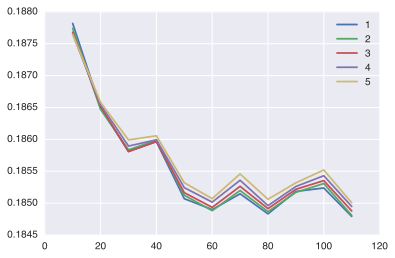

In [24]:
k_list = np.arange(1, 6, 1)
k_list_str = []
# bootstrap_size_mat = np.zeros(len(max_feature_list), len(bootstrap_size(10, 500, 10)))
# rmse_list_mat = np.copy(bootstrap_size_mat)
for temp_k in k_list:
    bootstrap_size, rmse_list = randomized_features(k_knn=temp_k, max_feature=10)
    plt.plot(bootstrap_size, rmse_list)
    k_list_str.append(str(temp_k))
plt.legend(k_list_str)
plt.show()

The figure below shows number of bootstrap times vs rmse when max_feature is 10

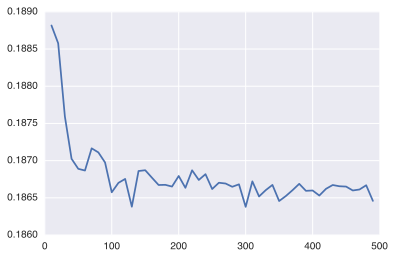

In [14]:
plt.plot(bootstrap_size, rmse_list)

In [26]:
def kNN_random_features_samples(num_bootstrap, library=None, sensor_data=None, max_feature=10, k_knn=20, pred_true=False):
    if pred_true:
        print num_bootstrap
        bootstrap_idx = np.random.randint(0, len(library), (num_bootstrap, len(library)))
        random_feature_idx = np.random.randint(0, len(library[0]), (num_bootstrap, max_feature))
        true = None
        pred = None
        for i in range(0, len(sensor_data)):
            sensor = sensor_data[i]
            kNN_result_bootstrap = np.zeros((num_bootstrap, len(sensor)))
            bootstrap_sample_idx = np.random.randint(0, len(library), (num_bootstrap, len(library)))
            bootstrap_feature_idx = np.random.randint(0, len(sensor), (num_bootstrap, max_feature))
            for j in range(0, num_bootstrap):
                temp_sample_idx = bootstrap_sample_idx[j]
                temp_feature_idx = bootstrap_feature_idx[j]
                library_bootstrap = library[temp_sample_idx]
                library_bootstrap_feature = library_bootstrap[:, temp_feature_idx]
                kNN = KDTree(library_bootstrap_feature)
                temp_sensor = sensor[temp_feature_idx]
                dist, ind = kNN.query(np.array([temp_sensor]), k=k_knn)
                ind = ind[0]
                kNN_result = library_bootstrap[ind]
                kNN_result_avg = np.nanmean(kNN_result, axis=0)
                kNN_result_bootstrap[j] = kNN_result_avg
            kNN_result_bootstrap_avg = np.nanmean(kNN_result_bootstrap, axis=0)
            if true is not None:
                true = np.append(true, sensor)
                pred = np.append(pred, kNN_result_bootstrap_avg)
            else:
                true = sensor
                pred = kNN_result_bootstrap_avg
        return true, pred
    else:
        print num_bootstrap
        bootstrap_idx = np.random.randint(0, len(library), (num_bootstrap, len(library)))
        random_feature_idx = np.random.randint(0, len(library[0]), (num_bootstrap, max_feature))
        error = None
        for i in range(0, len(sensor_data)):
            sensor = sensor_data[i]
            kNN_result_bootstrap = np.zeros((num_bootstrap, len(sensor)))
            bootstrap_sample_idx = np.random.randint(0, len(library), (num_bootstrap, len(library)))
            bootstrap_feature_idx = np.random.randint(0, len(sensor), (num_bootstrap, max_feature))
            for j in range(0, num_bootstrap):
                temp_sample_idx = bootstrap_sample_idx[j]
                temp_feature_idx = bootstrap_feature_idx[j]
                library_bootstrap = library[temp_sample_idx]
                library_bootstrap_feature = library_bootstrap[:, temp_feature_idx]
                kNN = KDTree(library_bootstrap_feature)
                temp_sensor = sensor[temp_feature_idx]
                dist, ind = kNN.query(np.array([temp_sensor]), k=k_knn)
                ind = ind[0]
                kNN_result = library_bootstrap[ind]
                kNN_result_avg = np.nanmean(kNN_result, axis=0)
                kNN_result_bootstrap[j] = kNN_result_avg
            kNN_result_bootstrap_avg = np.nanmean(kNN_result_bootstrap, axis=0)
            if error is not None:
                error = np.append(error, sensor - kNN_result_bootstrap_avg)
            else:
                error = sensor - kNN_result_bootstrap_avg
        rmse = np.sqrt(np.mean(error ** 2))
        return rmse

In [ ]:
def kNN_evaluate_Lidar(k_knn = 20):
    pass

In [ ]:
def kNN_timeSeries(k_knn = 20):
    date_list = [date(2013, 10, 1) + timedelta(days=i) for i in range(0, 366)]
    library_fn = "library_2001_2013.npy"
    library = np.load(library_fn)
    library_spatial_fn = pickle.load(open("library_file_name_list_2001_2013.p"))
    sensor_data_entireSeries = np.load("2014_sensor_data_filtered.npy").T
    sensor_data = sensor_data_entireSeries
    library_2014 = np.load("library_2014_2014_march.npy")
    sns.set_style("ticks", {'xtick.direction': u'in', 'ytick.direction': u'in'})
    plt.figure(figsize=(10, 7))
    for i in range(0, 20):
        kNN_list = []
        kNN_ci_list = []
        SSC = StandardScaler()
        SSC.fit(np.delete(library, i, 1))
        sensor_data_train = SSC.transform(np.delete(sensor_data, i, 1))
        library_train = SSC.transform(np.delete(library, i, 1))
        sensor_data_test = sensor_data[:, i]
        library_test = library[:, i]
        recon_test = library_2014[:, i]
        kNN = KDTree(library_train, metric="minkowski")
        for j, temp_data in enumerate(date_list):
            sensor = sensor_data_train[j]
            dist, ind = kNN.query(np.array([sensor]), k=k_knn)
            total_swe = 0.
            total_weight = 0.
            kNN_sensor_list = []
            for temp_dist, temp_ind in zip(dist[0], ind[0]):
                kNN_sensor_list.append(library_test[temp_ind])
                total_swe += 1./temp_dist * library_test[temp_ind]
                total_weight += 1./temp_dist
            kNN_list.append(total_swe / total_weight)
            kNN_ci_list.append(1.96 * np.nanstd(np.array(kNN_sensor_list)))
        plt.subplot(5, 5, i+1)
        plt.plot_date(date_list, sensor_data_test, '-r', linewidth=1)
        plt.plot_date(date_list, kNN_list, '-g', linewidth=1)
        plt.fill_between(date_list, np.array(kNN_list)-np.array(kNN_ci_list), np.array(kNN_list)+np.array(kNN_ci_list), alpha=0.5)
        plt.plot_date(date_list[151:151+len(recon_test)], recon_test, '--b', linewidth=1)
        plt.xlim([date(2013, 10, 1), date(2014, 6, 1)])
        plt.ylim([0, 1.2])
        if i == 0:
            plt.legend(["Ground measurement", "kNN estimate", "Reconstruction"], prop={'size':6})
        if i%5 != 0:
            plt.yticks([0., 0.4, 0.8, 1.2], [])
        else:
            plt.yticks([0., 0.4, 0.8, 1.2])
            if i < 15:
                plt.yticks([0., 0.4, 0.8, 1.2], ["", 0.4, 0.8, 1.2])
        if i < 15:
            plt.xticks([date(2013, 10, 1), date(2013, 12, 1), date(2014, 2, 1), date(2014, 4, 1), date(2014, 6, 1)], [])
        else:
            plt.xticks([date(2013, 10, 1), date(2013, 12, 1), date(2014, 2, 1), date(2014, 4, 1), date(2014, 6, 1)],
                       ["", "13 DEC", "", "14 APR", ""])
        plt.grid()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig("kNN_ts.pdf", dpi=300)
    plt.show()

In [ ]:
kNN_timeSeries(k_knn = 50)

In [ ]:
map_list = kNN_interpolate(k_knn = 10)

amr_data = gdal.Open("amr_watershed1.tif")
amr_geotransform = amr_data.GetGeoTransform()
amr_XCellSize = amr_data.RasterXSize
amr_YCellSize = amr_data.RasterYSize
amr_upperLeft = [amr_geotransform[0], amr_geotransform[3]]
amr_lowerRight = [amr_geotransform[1]*amr_XCellSize + amr_upperLeft[0], amr_geotransform[5]*amr_YCellSize + amr_upperLeft[1]]

swe_data = gdal.Open("2001/01APR2001.tif")
swe_geotransform = swe_data.GetGeoTransform()
upperLeft_idx = [int((amr_upperLeft[0] - swe_geotransform[0])/swe_geotransform[1]), int((amr_upperLeft[1] - swe_geotransform[3]) / swe_geotransform[5])]
lowerRight_idx = [int((amr_lowerRight[0] - swe_geotransform[0])/swe_geotransform[1]), int((amr_lowerRight[1] - swe_geotransform[3]) / swe_geotransform[5])]

amr_boundary = np.load("amr_shp/amr_watershed.npy")

# Calculate tick labels
y_ticks = [30 * swe_geotransform[5] + amr_geotransform[3],
           130 * swe_geotransform[5] + amr_geotransform[3],
           230 * swe_geotransform[5] + amr_geotransform[3]]
y_ticks = map(round, y_ticks, [1, 1, 1])
x_ticks = [75 * swe_geotransform[1] + amr_geotransform[0],
           175 * swe_geotransform[1] + amr_geotransform[0],
           275 * swe_geotransform[1] + amr_geotransform[0]]
x_ticks = map(round, x_ticks, [1, 1, 1])

sns.set_style('ticks')
count = 0
temp_date = date(2014, 3, 1)
fig, axarr = plt.subplots(ncols=2, nrows=5, figsize=(3.5, 7))
plt.subplots_adjust(left=0.13, right=0.85, top=0.9, bottom=0.1)

for j in range(0, 2):
    for i in range(0, 5):
        temp_map = map_list[count]
        temp_map[amr_shape<=1500.] = np.nan
        temp_map = temp_map[30:230, 75:]
        temp_map[amr_boundary==True] = np.nan
        im = axarr[i, j].imshow(temp_map, vmax=2.0, vmin=0., interpolation='nearest', cmap='cool')
        axarr[i, j].plot(amr_boundary[:, 0], amr_boundary[:, 1],'-k', linewidth=0.5)
        count += 1
        axarr[i, j].set_title(temp_date.strftime("%Y-%m-%d"))
        plt.sca(axarr[i, j])
        plt.ylim([200, 0])
        plt.xlim([0, 290])
        plt.xticks([0, 100, 200], x_ticks)
        plt.yticks([0, 100, 200], y_ticks)
#         axarr[i, j].set_xticks([0, 100, 200], x_ticks)
#         axarr[i, j].set_yticks([0, 100, 200], y_ticks)
        temp_date += timedelta(days=7)
        if i != 4:
            axarr[i, j].set_xticklabels([])
        if j != 0:
            axarr[i, j].set_yticklabels([])
cbar_ax = fig.add_axes([0.86, 0.11, 0.03, 0.78])
fig.colorbar(im, cax=cbar_ax)
plt.savefig("weekly_swe_map.pdf", dpi=300)
plt.show()

In [ ]:
map_list = query_corr_map()

amr_data = gdal.Open("amr_watershed1.tif")
amr_geotransform = amr_data.GetGeoTransform()
amr_XCellSize = amr_data.RasterXSize
amr_YCellSize = amr_data.RasterYSize
amr_upperLeft = [amr_geotransform[0], amr_geotransform[3]]
amr_lowerRight = [amr_geotransform[1]*amr_XCellSize + amr_upperLeft[0], amr_geotransform[5]*amr_YCellSize + amr_upperLeft[1]]

swe_data = gdal.Open("2001/01APR2001.tif")
swe_geotransform = swe_data.GetGeoTransform()
upperLeft_idx = [int((amr_upperLeft[0] - swe_geotransform[0])/swe_geotransform[1]), int((amr_upperLeft[1] - swe_geotransform[3]) / swe_geotransform[5])]
lowerRight_idx = [int((amr_lowerRight[0] - swe_geotransform[0])/swe_geotransform[1]), int((amr_lowerRight[1] - swe_geotransform[3]) / swe_geotransform[5])]

amr_boundary = np.load("amr_shp/amr_watershed.npy")

# Calculate tick labels
y_ticks = [30 * swe_geotransform[5] + amr_geotransform[3],
           130 * swe_geotransform[5] + amr_geotransform[3],
           230 * swe_geotransform[5] + amr_geotransform[3]]
y_ticks = map(round, y_ticks, [1, 1, 1])
x_ticks = [75 * swe_geotransform[1] + amr_geotransform[0],
           175 * swe_geotransform[1] + amr_geotransform[0],
           275 * swe_geotransform[1] + amr_geotransform[0]]
x_ticks = map(round, x_ticks, [1, 1, 1])

sns.set_style('ticks')
count = 0
temp_date = date(2014, 3, 1)
fig, axarr = plt.subplots(ncols=2, nrows=5, figsize=(3.5, 7))
plt.subplots_adjust(left=0.13, right=0.85, top=0.9, bottom=0.1)
for j in range(0, 2):
    for i in range(0, 5):
        temp_map = map_list[count]
        temp_map[amr_shape<=1500.] = np.nan
        temp_map = temp_map[30:230, 75:]
        temp_map[amr_boundary==True] = np.nan
        
        im = axarr[i, j].imshow(temp_map, vmax=2.0, vmin=0., interpolation='nearest', cmap='cool')
        axarr[i, j].plot(amr_boundary[:, 0], amr_boundary[:, 1],'-k', linewidth=0.5)
        count += 1
        axarr[i, j].set_title(temp_date.strftime("%Y-%m-%d"))
        plt.sca(axarr[i, j])
        plt.ylim([200, 0])
        plt.xlim([0, 290])
        plt.xticks([0, 100, 200], x_ticks)
        plt.yticks([0, 100, 200], y_ticks)
#         axarr[i, j].set_xticks([0, 100, 200], x_ticks)
#         axarr[i, j].set_yticks([0, 100, 200], y_ticks)
        temp_date += timedelta(days=7)
        if i != 4:
            axarr[i, j].set_xticklabels([])
        if j != 0:
            axarr[i, j].set_yticklabels([])
cbar_ax = fig.add_axes([0.86, 0.11, 0.03, 0.78])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.tick_params(labelsize=10)
plt.savefig("weekly_swe_map_recon.pdf", dpi=300)
plt.show()

In [ ]:
import shapefile
sf = shapefile.Reader("amr_shp/amr_watershed")
shapes = sf.shapes()
for shape in shapes:
    print len(shape.points)
    coordinates = np.zeros((len(shape.points), 2))
    for i, vertex in enumerate(shape.points):
        coordinates[i]=vertex
        
amr_data = gdal.Open("amr_watershed1.tif")
amr_geotransform = amr_data.GetGeoTransform()

swe_data = gdal.Open("2001/01APR2001.tif")
swe_geotransform = swe_data.GetGeoTransform()

locations = np.copy(coordinates)
locations[:, 0] = (coordinates[:, 0] - amr_geotransform[0]) / swe_geotransform[1]-75
locations[:, 1] = (coordinates[:, 1] - amr_geotransform[3]) / swe_geotransform[5]-30

plt.plot(locations[:, 0], locations[:, 1], 'k')
np.save("amr_shp/amr_watershed.npy", locations)

In [ ]:
# amr_data = gdal.Open("amr_watershed1.tif")
# amr_geotransform = amr_data.GetGeoTransform()
# amr_XCellSize = amr_data.RasterXSize
# amr_YCellSize = amr_data.RasterYSize
# amr_upperLeft = [amr_geotransform[0], amr_geotransform[3]]
# amr_lowerRight = [amr_geotransform[1]*amr_XCellSize + amr_upperLeft[0], amr_geotransform[5]*amr_YCellSize + amr_upperLeft[1]]

# swe_data = gdal.Open("2001/01APR2001.tif")
# swe_geotransform = swe_data.GetGeoTransform()
# upperLeft_idx = [int((amr_upperLeft[0] - swe_geotransform[0])/swe_geotransform[1]), int((amr_upperLeft[1] - swe_geotransform[3]) / swe_geotransform[5])]
# lowerRight_idx = [int((amr_lowerRight[0] - swe_geotransform[0])/swe_geotransform[1]), int((amr_lowerRight[1] - swe_geotransform[3]) / swe_geotransform[5])]

# swe_amr = swe_data.ReadAsArray()[upperLeft_idx[1]:lowerRight_idx[1], upperLeft_idx[0]:lowerRight_idx[0]]
# swe_amr_shape = swe_amr.shape
# amr_boundary = amr_data.ReadAsArray().astype(float)
# amr_boundary = resize(amr_boundary, swe_amr_shape)
# swe_amr[amr_boundary <= 1500.] = np.nan
# amr_boundary[amr_boundary > 0.] = 1.
# amr_boundary[amr_boundary <= 0.] = 0.
# amr_boundary = feature.canny(amr_boundary)
# sns.set_style('ticks')
# plt.imshow(amr_boundary)
# plt.imshow(swe_amr)
# plt.show()

def clip_mask_reconstructions(fn):
    amr_data = gdal.Open("amr_watershed1.tif")
    amr_geotransform = amr_data.GetGeoTransform()
    amr_XCellSize = amr_data.RasterXSize
    amr_YCellSize = amr_data.RasterYSize
    amr_upperLeft = [amr_geotransform[0], amr_geotransform[3]]
    amr_lowerRight = [amr_geotransform[1]*amr_XCellSize + amr_upperLeft[0], amr_geotransform[5]*amr_YCellSize + amr_upperLeft[1]]

    swe_data = gdal.Open(fn)
    swe_geotransform = swe_data.GetGeoTransform()
    upperLeft_idx = [int((amr_upperLeft[0] - swe_geotransform[0])/swe_geotransform[1]), int((amr_upperLeft[1] - swe_geotransform[3]) / swe_geotransform[5])]
    lowerRight_idx = [int((amr_lowerRight[0] - swe_geotransform[0])/swe_geotransform[1]), int((amr_lowerRight[1] - swe_geotransform[3]) / swe_geotransform[5])]

    swe_amr = swe_data.ReadAsArray()[upperLeft_idx[1]:lowerRight_idx[1], upperLeft_idx[0]:lowerRight_idx[0]]
    return swe_amr

In [ ]:
def query_corr_map():
    start_date = date(2014, 3, 1)
    map_list = []
    for i in range(0, 10):
        temp_date = start_date + timedelta(days=i*7)
        temp_fn = "2014/" + temp_date.strftime("%d%b%Y").upper() + ".tif"
        map_list.append(clip_mask_reconstructions(temp_fn))
    return map_list

In [ ]:
observed, predict, index = kNN_kfold_CV([2001, 2013], 2014, 10, k_knn=50, return_ = "true_vs_predict")
print observed.shape
print np.unique(index)
plt.figure(figsize=(3.5, 3.25))
plt.scatter(observed, predict, c=index, cmap='viridis', s=np.ones(len(observed))*1, edgecolors='none')
plt.plot([0, 1.2], [0, 1.2], '-k')
plt.xlim([0, 1.2])
plt.ylim([0, 1.2])
plt.xlabel('Ground measurements, m')
plt.ylabel('kNN estimations, m')
plt.grid()
plt.colorbar()
plt.tight_layout()
plt.savefig("obs_pred_scatter.eps")
print pearsonr(observed, predict)

In [ ]:
error = []
std = []
for k in range(1, 200):
    print k
    cv_error_mean, cv_error_std = kNN_kfold_CV([2001, 2013], 2014, 6, k_knn=k)
    error.append(cv_error_mean)
    std.append(cv_error_std)
error = np.array(error)
std = np.array(std)
plt.plot(range(1, 200), error)
plt.fill_between(range(1, 200), error+std)
plt.show()

In [ ]:
all_error = kNN_kfold_CV([2001, 2013], 2014, 21, k_knn=50, return_ = "all_error")
plt.hist(all_error, bins=20)
plt.show()

In [ ]:
table = np.column_stack((np.column_stack((observed, predict)), index))
new_slope_list = []
for i in range(21):
    temp_table = table[table[:, 2]==i]
    x=temp_table[:, 0]
    y=temp_table[:, 1]
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    new_slope_list.append(slope)

In [ ]:
plt.scatter(slope_list, new_slope_list)
plt.show()
print pearsonr(slope_list, new_slope_list)

In [ ]:
print cv_error_mean, cv_error_std

In [ ]:
from multiprocessing import Pool, cpu_count

In [ ]:
print all_nodes_indices
data = gdal.Open("2014/01APR2014.tif", GA_ReadOnly).ReadAsArray()
data[data > 2.] = 0.
plt.figure(figsize=(15, 15))
plt.imshow(data)
plt.plot(all_nodes_indices[:, 1], all_nodes_indices[:, 0], ".r")
plt.colorbar()
plt.show()